In [ ]:
# Good resources
# https://colab.research.google.com/github/deepmind/deepmind-research/blob/master/polygen/training.ipynb
# https://towardsdatascience.com/generating-3d-models-with-polygen-and-pytorch-4895f3f61a2e

# https://pytorch3d.org/tutorials/render_textured_meshes

## Attempt 2 (Using PyTorch3D)

In [ ]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
# print(pyt_version_str)
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py37_cu111_pyt1100/download.html
     |████████████████████████████████| 44.7 MB 1.4 MB/s 


In [ ]:
import pytorch3d as p3d
print(p3d.__version__)

0.6.1


In [ ]:
!pip uninstall pytorch3d

Found existing installation: pytorch3d 0.3.0
Uninstalling pytorch3d-0.3.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pytorch3d-0.3.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pytorch3d/*
Proceed (y/n)? y
  Successfully uninstalled pytorch3d-0.3.0


In [ ]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj,load_objs_as_meshes

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [ ]:
# verts_l, faces_l, aux_l = load_obj(f'{data_path}/{fname}/{fname}_lower.obj')
# verts_u, faces_u, aux_u = load_obj(f'{data_path}/{fname}/{fname}_upper.obj')
# verts_u, faces_u, _= load_obj('/content/016KWDMV_upper.obj')
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2022-04-21 18:11:34--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘teapot.obj’

teapot.obj          100%[===================>] 149.02K   985KB/s    in 0.2s    

2022-04-21 18:11:34 (985 KB/s) - ‘teapot.obj’ saved [152595/152595]



In [ ]:
# verts_u, faces_u, _ = load_obj("/content/teapot.obj")
verts_u, faces_u, _= load_obj('/content/016KWDMV_upper.obj')
print(verts_u.shape)
print(faces_u.textures_idx.shape)
# print(aux_u)

torch.Size([158937, 3])
torch.Size([317732, 3])


In [ ]:
# !rm -rf /content/data

In [ ]:

# device = torch.device("cuda:0")
# verts_u, faces_u, _= load_obj('/content/016KWDMV_upper.obj')
faces = faces_u.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts_u)[None]  # (1, V, 3)

textures = TexturesVertex(verts_features=verts_rgb.to('cuda'))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
mesh = Meshes(
    verts=[verts_u.to('cuda')],   
    faces=[faces.to('cuda')], 
    textures=textures
)

In [ ]:
print(verts_u)
print(verts_rgb)

tensor([[  4.7734, -29.8470, -89.8121],
        [  4.7664, -29.8935, -90.1084],
        [  4.7804, -29.8005, -89.5158],
        ...,
        [ -2.2423,  -9.6680, -89.4534],
        [ 19.1244,  15.4907, -92.5954],
        [ 16.0988, -18.3681, -90.0713]])
tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])


In [ ]:
# plt.figure(figsize=(7,7))
# print(mesh.textures)
# # texturesuv_image_matplotlib(mesh.textures, subsample=None)
# plt.axis("off");

In [ ]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device='cuda')

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device='cuda', location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device='cuda', cameras=cameras, lights=lights)
)

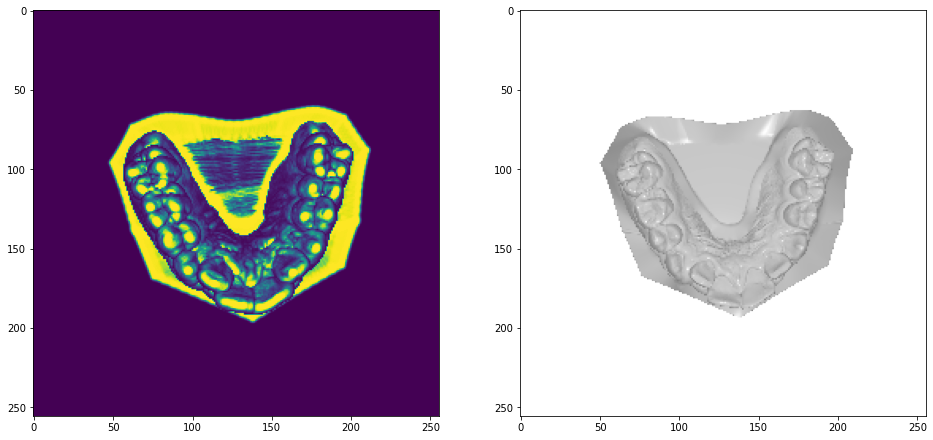

In [ ]:
# Select the viewpoint using spherical angles  
distance = 10   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device='cuda')

# Render the teapot providing the values of R and T. 
silhouette = silhouette_renderer(meshes_world=mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)